# Understand the data and efficiencies of graph formation selections

In [2]:
import os
import sys

# and for local code
sys.path.append('..')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import trackml.dataset

## Load the data

In [4]:
data_dir = '/global/homes/x/xju/atlas/heptrkx/trackml_inputs/train_all'
black_list_dir = '/global/homes/x/xju/atlas/heptrkx/trackml_inputs/blacklist'

In [5]:
evtid = 6600
prefix = os.path.join(data_dir, 'event{:09d}'.format(evtid))
prefix_bl = os.path.join(black_list_dir, 'event{:09d}-blacklist_'.format(evtid))

In [6]:
hits_exclude = pd.read_csv(prefix_bl+'hits.csv')
particles_exclude = pd.read_csv(prefix_bl+'particles.csv')

In [7]:
hits, particles, truth = trackml.dataset.load_event(
    prefix, parts=['hits', 'particles', 'truth'])

In [8]:
hits = hits[~hits['hit_id'].isin(hits_exclude['hit_id'])]
particles = particles[~particles['particle_id'].isin(particles_exclude['particle_id'])]

In [9]:
hits.shape

(113668, 7)

In [10]:
particles.shape

(11170, 9)

In [11]:
tot_particles = particles.shape[0]

In [12]:
px = particles.px
py = particles.py
pt = np.sqrt(px**2 + py**2)
particles = particles.assign(pt=pt)

## remove particles that do not leave a hit

In [13]:
truth_particles = particles.merge(truth, on='particle_id', how='left')

In [14]:
reconstructable_particles = truth_particles[~np.isnan(truth_particles.weight)]

In [15]:
reconstructable_particles.shape

(95687, 18)

In [16]:
reconstructable_particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pt,hit_id,tx,ty,tz,tpx,tpy,tpz,weight
0,4503668346847232,-0.024631,-0.000457,6.72595,-0.505992,-1.59523,1.72873,-1,12,1.673555,20402.0,-9.643060,-30.945400,40.205601,-0.487816,-1.60070,1.72855,0.000039
1,4503668346847232,-0.024631,-0.000457,6.72595,-0.505992,-1.59523,1.72873,-1,12,1.673555,28815.0,-20.957300,-69.141403,81.379601,-0.462740,-1.60673,1.72910,0.000033
2,4503668346847232,-0.024631,-0.000457,6.72595,-0.505992,-1.59523,1.72873,-1,12,1.673555,35081.0,-32.765400,-111.283997,126.685997,-0.438239,-1.61292,1.72897,0.000028
3,4503668346847232,-0.024631,-0.000457,6.72595,-0.505992,-1.59523,1.72873,-1,12,1.673555,41335.0,-46.579102,-164.350006,183.412994,-0.404453,-1.62118,1.72873,0.000023
4,4503668346847232,-0.024631,-0.000457,6.72595,-0.505992,-1.59523,1.72873,-1,12,1.673555,41347.0,-47.028702,-166.154999,185.337006,-0.403087,-1.62212,1.72811,0.000020


In [17]:
len(np.unique(reconstructable_particles.particle_id))

9635

### remove particles with weight == 0, i.e. non-constructable particles

In [18]:
truth_particles = particles.merge(truth, on='particle_id', how='left')
non_recostructable_particles = truth_particles[truth_particles.weight.abs() < 1e-7]

In [19]:
recostructable_particles = truth_particles[~truth_particles['particle_id'].isin(np.unique(non_recostructable_particles.particle_id))]
recostructable_particles.shape

(95370, 18)

### remove noise hits
Their weights are zero

In [22]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,418835796137607168,-62.044899,-8.80437,-1502.5,-0.275382,-0.019044,-6.58252,0.000010
1,2,211686362355597312,-56.781799,2.68623,-1502.5,-0.222526,0.027606,-5.80354,0.000008
2,3,517920279339466752,-88.781898,-4.98339,-1502.5,-0.526577,-0.000612,-8.85540,0.000008
3,4,616995416692490240,-68.249702,-9.66492,-1502.5,-0.424269,-0.083626,-9.49401,0.000008
4,5,0,-90.478897,-14.19510,-1502.5,-605192.000000,-319191.000000,-729287.00000,0.000000


In [23]:
hits = hits.merge(truth, on='hit_id', how='left')
hits.shape

(113668, 15)

In [24]:
hits_no_noise = hits[hits['particle_id'] != 0]
hits_no_noise.shape

(95687, 15)

In [25]:
hits_with_noise = hits[hits['particle_id'] == 0]
hits_with_noise.shape

(17981, 15)

In [26]:
hits_with_noise.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
4,5,-90.476799,-14.19560,-1502.5,7,2,1,0,-90.478897,-14.19510,-1502.5,-605192.000000,-319191.000000,-729287.0,0.0
12,13,-175.481995,-11.73980,-1502.0,7,2,2,0,-175.475006,-11.73800,-1502.0,-712801.000000,-141456.000000,-686953.0,0.0
17,18,-160.253998,-7.88448,-1502.0,7,2,2,0,-160.263000,-7.88796,-1502.0,72055.101562,-10575.299805,-997345.0,0.0
25,26,-107.153999,-11.62250,-1498.0,7,2,3,0,-107.153999,-11.61800,-1498.0,294730.000000,125584.000000,-947292.0,0.0
41,42,-49.432598,-11.50780,-1498.0,7,2,4,0,-49.436001,-11.51160,-1498.0,151245.000000,171064.000000,-973582.0,0.0


In [27]:
tpx = hits_with_noise.tpx
tpy = hits_with_noise.tpy
tpt = np.sqrt(tpx**2 + tpy**2)
hits_with_noise = hits_with_noise.assign(tpt=tpt)

In [28]:
hits_with_noise.describe()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,tpt
count,17981.000000,17981.000000,17981.000000,17981.000000,17981.000000,17981.000000,17981.000000,17981.0,17981.000000,17981.000000,17981.000000,17981.000000,17981.000000,17981.000000,17981.0,1.798100e+04
mean,80274.559035,-0.540786,-3.569317,0.123575,13.449919,5.429175,758.874701,0.0,-0.542579,-3.571928,0.144708,925.832031,-4909.362793,155.381348,0.0,6.323655e+05
std,28978.741168,468.733704,466.668091,1064.204956,3.363318,2.888482,780.108455,0.0,468.715485,466.671387,1064.201538,496425.687500,489968.843750,716604.125000,0.0,2.943186e+05
min,5.000000,-1024.280029,-1025.170044,-2955.500000,7.000000,2.000000,1.000000,0.0,-1024.280029,-1025.170044,-2955.500000,-999889.000000,-999427.000000,-1000000.000000,0.0,7.221105e+01
25%,64379.000000,-303.970001,-305.723999,-623.400024,12.000000,4.000000,96.000000,0.0,-303.953003,-305.713013,-625.870972,-360422.000000,-358939.000000,-727708.000000,0.0,3.822332e+05
50%,87700.000000,-1.146870,-4.361710,-5.096170,13.000000,4.000000,499.000000,0.0,-1.147760,-4.362890,-3.561310,1769.390015,-4065.520020,855.784973,0.0,6.851878e+05
75%,104625.000000,305.928986,297.334991,634.200012,17.000000,8.000000,1198.000000,0.0,305.917999,297.229004,633.414001,355648.000000,344786.000000,728940.000000,0.0,9.107042e+05
max,113785.000000,1024.760010,1024.180054,2955.500000,18.000000,14.000000,3189.000000,0.0,1024.750000,1024.180054,2955.500000,999899.000000,999801.000000,1000000.000000,0.0,1.000000e+06


pT distribution of noise hits

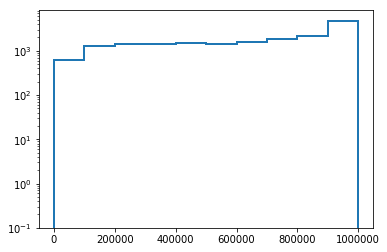

In [29]:
fig, ax = plt.subplots()
vals, bins, _ = ax.hist(hits_with_noise['tpt'], histtype='step', lw=2, label='noise', log=True)

In [30]:
hits_no_noise = hits_no_noise.merge(particles, on='particle_id')
hits_no_noise.shape

(95687, 24)

In [31]:
import matplotlib.pyplot as plt

pT distribution of particles in this event

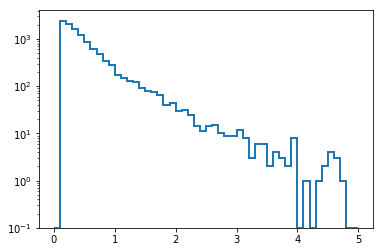

In [32]:
fig, ax = plt.subplots()
bins = np.linspace(0, 5, 51)
tot_vals, bins, _ = ax.hist(particles['pt'], bins=bins, histtype='step', lw=2, label='no-noise', log=True)

## Seletect hits at barrel layers

In [33]:
vlids = [(8,2), (8,4), (8,6), (8,8),
         (13,2), (13,4), (13,6), (13,8),
         (17,2), (17,4)]
n_det_layers = len(vlids)

# Select barrel layers and assign convenient layer number [0-9]
vlid_groups = hits_no_noise.groupby(['volume_id', 'layer_id'])
hits_barrel = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i)
                  for i in range(n_det_layers)])

In [34]:
hits_barrel.shape

(47989, 25)

In [35]:
hits_barrel.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vx,vy,vz,px,py,pz,q,nhits,pt,layer
211,16181,-31.937000,0.854461,-311.917999,8,2,48,418837307966095360,-31.937799,0.84008,...,0.001866,-0.010319,-1.984870,-0.321843,0.018488,-3.12345,-1,13,0.322374,0
250,16588,-31.398800,1.605670,-271.118011,8,2,64,211690073207341056,-31.399300,1.59701,...,0.018914,0.003020,-0.489561,-0.670819,0.043316,-5.78108,-1,15,0.672216,0
278,15959,-31.528601,8.095710,-488.497009,8,2,16,171140359252869120,-31.528799,8.09068,...,-12.166900,11.274100,-311.657990,-0.249725,-0.035172,-2.26913,-1,15,0.252190,0
485,16011,-30.985100,-8.137190,-311.738007,8,2,33,103589732096671744,-30.986601,-8.13293,...,0.005339,0.005712,-0.453590,-0.586576,-0.163658,-5.91685,1,10,0.608979,0
539,16200,-30.657700,-7.573420,-263.018005,8,2,49,517919111108362240,-30.658199,-7.57199,...,-0.007501,0.015426,10.662300,-1.357800,-0.345717,-12.14450,1,11,1.401121,0


In [36]:
barrel_particles = np.unique(hits_barrel['particle_id'])
tot_barrel_particles = len(barrel_particles)
print(tot_barrel_particles, "{:.3f}".format(tot_barrel_particles/tot_particles))

7492 0.671


In [52]:
np.savez("hello.npz", barrel_particles)

In [53]:
np.savez("hello_pt.npz", particles.pt.values)

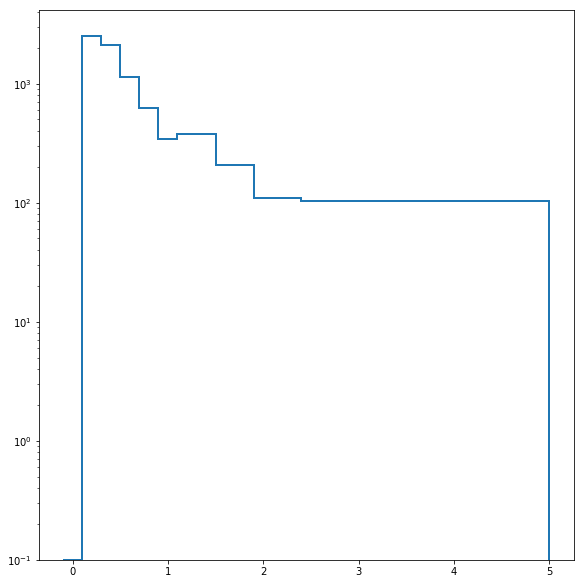

In [42]:
fontsize=16
minor_size=14
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.5, 1.9, 2.4, 5]
hist_configs = {
    'bins': bins,
    'histtype': 'step',
    'lw': 2,
    'log': True
}

bb_vals, bins, _ = plt.hist(particles[particles.particle_id.isin(barrel_particles)]['pt'], **hist_configs, label='barrel')

In [48]:
bb_vals

array([    0.,  2487.,  2092.,  1133.,   626.,   343.,   374.,   207.,
         110.,   104.])

In [44]:
bins

array([-0.1,  0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.5,  1.9,  2.4,  5. ])

In [46]:
_

<a list of 1 Patch objects>

In [51]:
sum(barrel_particles)

/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in long_scalars
  """Entry point for launching an IPython kernel.


7714113270454720522

In [37]:
barrel_particles[:10]

array([4503668346847232, 4503805785800704, 4503874505277440,
       4503943224754176, 4504011944230912, 4504286822137856,
       4504355541614592, 4504424261091328, 4504561700044800,
       4504630419521536])

In [35]:
n_particles = [0]*10 # 100%, 70%, 50%, >3 hits, =1, =2, =3
dict_pp = {"not-l0": []}
for pid in barrel_particles:
    hits_selected = hits_barrel[hits_barrel['particle_id'] == pid]
    hits_in_particles = truth[truth['particle_id'] == pid]
    if hits_in_particles.shape[0] == hits_selected.shape[0]:
        n_particles[0] += 1
    
    if hits_selected.shape[0] > 0.7 * hits_in_particles.shape[0]:
        n_particles[1] += 1
    
    if hits_selected.shape[0] > 0.5 * hits_in_particles.shape[0]:
        n_particles[2] += 1
    
    if hits_selected.shape[0] > 3:
        n_particles[3] += 1
        
    if hits_selected.shape[0] == 3:
        n_particles[4] += 1
    if hits_selected.shape[0] == 2:
        n_particles[5] += 1
    if hits_selected.shape[0] == 1:
        n_particles[6] += 1
        
    if 0 not in hits_selected['layer'].values:
        n_particles[7] += 1
        dict_pp['not-l0'].append(pid)
        
    if 1 not in hits_selected['layer'].values:
        n_particles[8] += 1

In [36]:
cuts = ['100%', '70%', '50%', '> 3', '= 1', '= 2', '= 3', 'not l0', 'not l1']
for ii, nn in enumerate(cuts):
    print("{}\t {}".format(nn, n_particles[ii]))

100%	 3227
70%	 4460
50%	 5223
> 3	 5152
= 1	 538
= 2	 873
= 3	 929
not l0	 1394
not l1	 2033


In [37]:
["{:.3f}".format(x/tot_particles) for x in n_particles]

['0.289',
 '0.399',
 '0.468',
 '0.461',
 '0.048',
 '0.078',
 '0.083',
 '0.125',
 '0.182',
 '0.000']

In [38]:
hits_barrel_no_layer0 = hits_barrel[hits_barrel['particle_id'].isin(dict_pp['not-l0'])]
hits_barrel_no_layer0.sort_values('particle_id').head(20)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vx,vy,vz,px,py,pz,q,nhits,pt,layer
79384,71652,-259.860992,-8.876690,445.000000,13,2,561,4507035617988609,-259.859985,-8.865300,...,-67.993401,31.568300,345.247986,-0.143193,-0.088302,0.086228,1,4,0.168230,4
79385,78616,-356.455994,27.178400,496.399994,13,4,896,4507035617988609,-356.459015,27.167999,...,-67.993401,31.568300,345.247986,-0.143193,-0.088302,0.086228,1,4,0.168230,5
79383,42454,-171.878998,-8.204190,401.989014,8,8,937,4507035617988609,-171.880005,-8.198800,...,-67.993401,31.568300,345.247986,-0.143193,-0.088302,0.086228,1,4,0.168230,3
79382,37075,-116.106003,7.871170,372.765991,8,6,676,4507035617988609,-116.106003,7.872170,...,-67.993401,31.568300,345.247986,-0.143193,-0.088302,0.086228,1,4,0.168230,2
79275,42141,-170.925995,-26.903799,323.955994,8,8,861,4507035618004994,-170.923996,-26.911400,...,-67.993401,31.568300,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,3
79274,42139,-169.029999,-26.202700,324.329987,8,8,860,4507035618004994,-169.035004,-26.184200,...,-67.993401,31.568300,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,3
79277,77607,-353.656006,-47.982899,286.799988,13,4,730,4507035618004994,-353.654999,-48.009800,...,-67.993401,31.568300,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,5
79279,89064,-638.539001,175.994995,211.399994,13,8,1322,4507035618004994,-638.539978,175.992004,...,-67.993401,31.568300,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,7
79278,83608,-503.053009,10.018500,254.119995,13,6,1014,4507035618004994,-503.058990,9.987500,...,-67.993401,31.568300,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,6
79276,71236,-252.380005,-48.439301,308.399994,13,2,522,4507035618004994,-252.380005,-48.429001,...,-67.993401,31.568300,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,4


### Remove duplicated Hits

In [39]:
x = hits_barrel.x
y = hits_barrel.y
r = np.sqrt(x**2 + y**2)
phi = np.arctan2(y, x)
hits_barrel = hits_barrel.assign(r=r, phi=phi)

In [40]:
hits_barrel_no_duplicate_hits = hits_barrel.loc[hits_barrel.groupby(['particle_id', 'layer'], as_index=False).r.idxmin()]

In [41]:
hits_barrel_no_duplicate_hits.shape

(38753, 27)

In [42]:
hits_barrel_no_duplicate_hits.shape[0]/hits_barrel.shape[0]

0.8075392277396903

In [43]:
n_particles = [0]*10 # 100%, 70%, 50%, >3 hits, =1, =2, =3
dict_pp = {
    "not-l0": [],
    "=1": []
}
for pid in barrel_particles:
    hits_selected = hits_barrel_no_duplicate_hits[hits_barrel_no_duplicate_hits['particle_id'] == pid]
    hits_in_particles = truth[truth['particle_id'] == pid]
    if hits_in_particles.shape[0] == hits_selected.shape[0]:
        n_particles[0] += 1
    
    if hits_selected.shape[0] > 0.7 * hits_in_particles.shape[0]:
        n_particles[1] += 1
    
    if hits_selected.shape[0] > 0.5 * hits_in_particles.shape[0]:
        n_particles[2] += 1
    
    if hits_selected.shape[0] > 3:
        n_particles[3] += 1
        
    if hits_selected.shape[0] == 3:
        n_particles[4] += 1
    if hits_selected.shape[0] == 2:
        n_particles[5] += 1
    if hits_selected.shape[0] == 1:
        n_particles[6] += 1
        dict_pp['=1'].append(pid)
        
    if 0 not in hits_selected['layer'].values:
        n_particles[7] += 1
        dict_pp['not-l0'].append(pid)
        
    if 1 not in hits_selected['layer'].values:
        n_particles[8] += 1

In [44]:
cuts = ['100%', '70%', '50%', '> 3', '= 1', '= 2', '= 3', 'not l0', 'not l1']
for ii, nn in enumerate(cuts):
    print("{}\t {}".format(nn, n_particles[ii]))

100%	 957
70%	 3164
50%	 4570
> 3	 4821
= 1	 386
= 2	 1119
= 3	 1166
not l0	 1394
not l1	 2033


In [45]:
particle_with_one_hit = dict_pp['=1'][0]

In [46]:
hits_barrel_nodup_nolayer0 = hits_barrel_no_duplicate_hits[hits_barrel_no_duplicate_hits['particle_id'].isin(dict_pp['not-l0'])]
hits_barrel_nodup_nolayer0.sort_values(['particle_id', 'layer']).head(20)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vz,px,py,pz,q,nhits,pt,layer,r,phi
79382,37075,-116.106003,7.871170,372.765991,8,6,676,4507035617988609,-116.106003,7.872170,...,345.247986,-0.143193,-0.088302,0.086228,1,4,0.168230,2,116.372498,3.073903
79383,42454,-171.878998,-8.204190,401.989014,8,8,937,4507035617988609,-171.880005,-8.198800,...,345.247986,-0.143193,-0.088302,0.086228,1,4,0.168230,3,172.074692,-3.093896
79384,71652,-259.860992,-8.876690,445.000000,13,2,561,4507035617988609,-259.859985,-8.865300,...,345.247986,-0.143193,-0.088302,0.086228,1,4,0.168230,4,260.012573,-3.107447
79385,78616,-356.455994,27.178400,496.399994,13,4,896,4507035617988609,-356.459015,27.167999,...,345.247986,-0.143193,-0.088302,0.086228,1,4,0.168230,5,357.490601,3.065494
79273,36815,-114.974998,-0.083634,335.191986,8,6,624,4507035618004994,-114.974998,-0.084399,...,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,2,114.975029,-3.140865
79274,42139,-169.029999,-26.202700,324.329987,8,8,860,4507035618004994,-169.035004,-26.184200,...,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,3,171.048889,-2.987799
79276,71236,-252.380005,-48.439301,308.399994,13,2,522,4507035618004994,-252.380005,-48.429001,...,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,4,256.986450,-2.951969
79277,77607,-353.656006,-47.982899,286.799988,13,4,730,4507035618004994,-353.654999,-48.009800,...,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,5,356.896240,-3.006739
79278,83608,-503.053009,10.018500,254.119995,13,6,1014,4507035618004994,-503.058990,9.987500,...,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,6,503.152771,3.121680
79279,89064,-638.539001,175.994995,211.399994,13,8,1322,4507035618004994,-638.539978,175.992004,...,345.247986,-0.175617,-0.138600,-0.039662,1,9,0.223721,7,662.349060,2.872649


In [47]:
hits_barrel[hits_barrel['particle_id'] == 4507035634769922]

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vz,px,py,pz,q,nhits,pt,layer,r,phi
89867,78839,-314.377014,177.490005,653.400024,13,4,948,4507035634769922,-314.388,177.475998,...,582.179016,0.147296,0.064804,0.071765,1,3,0.160921,5,361.020233,2.627627


### Make pairs

In [48]:
gid_keys = 'layer'
n_det_layers = 10
gid_start = np.arange(0, n_det_layers-1)
gid_end = np.arange(1, n_det_layers)

In [49]:
print(gid_start)
print(gid_end)

[0 1 2 3 4 5 6 7 8]
[1 2 3 4 5 6 7 8 9]


In [50]:
def cal_deta(hitpair):
    r1 = hitpair.r_1
    r2 = hitpair.r_2
    z1 = hitpair.z_1
    z2 = hitpair.z_2
    
    R1 = np.sqrt(r1**2 + z1**2)
    R2 = np.sqrt(r2**2 + z2**2)
    theta1 = np.arccos(z1/R1)
    theta2 = np.arccos(z2/R2)
#     theta1 = np.arctan(r1/z1)
#     theta2 = np.arctan(r2/z2)
    eta1 = -np.log(np.tan(theta1/2.0))
    eta2 = -np.log(np.tan(theta2/2.0))
    return eta1 - eta2

def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

In [51]:
hits_barrel_no_duplicate_hits = hits_barrel_no_duplicate_hits.assign(evtid=evtid)

### Number of hits not in adjacent layers

In [52]:
hits_barrel_no_duplicate_hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,px,py,pz,q,nhits,pt,layer,r,phi,evtid
47472,20402,-9.644350,-30.945299,40.206699,8,2,116,4503668346847232,-9.643060,-30.945400,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,0,32.413345,-1.872914,6600
47473,28815,-20.955299,-69.141701,81.374001,8,4,263,4503668346847232,-20.957300,-69.141403,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,1,72.247482,-1.865074,6600
47474,35081,-32.765400,-111.283997,126.690002,8,6,427,4503668346847232,-32.765400,-111.283997,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,2,116.007324,-1.857136,6600
47475,41335,-46.580502,-164.350006,183.408997,8,8,718,4503668346847232,-46.579102,-164.350006,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,3,170.823502,-1.846976,6600
47477,71311,-66.118301,-249.014008,273.000000,13,2,529,4503668346847232,-66.138298,-249.005997,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,4,257.642395,-1.830328,6600


In [53]:
from postprocess import utils_fit

In [54]:
n_not_in_adjacent_layers = 0
n_not_in_adjacent_layers_particles = 0
pps = np.unique(hits_barrel_no_duplicate_hits['particle_id'])
broken_tracks = []
for pp in pps:
    layer_info = hits_barrel_no_duplicate_hits[hits_barrel_no_duplicate_hits['particle_id'] == pp]['layer'].values
    layer_info = list(np.sort(layer_info))
    layer_pairs = utils_fit.pairwise(layer_info)
    is_broken = False
    for b,a in layer_pairs:
        if abs(a-b) != 1:
            n_not_in_adjacent_layers += 1
            is_broken = True
    if is_broken:
        n_not_in_adjacent_layers_particles += 1
        broken_tracks.append(pp)

In [55]:
print(n_not_in_adjacent_layers, n_not_in_adjacent_layers_particles)

902 892


In [56]:
a = [9]
bb = utils_fit.pairwise(a)
print(list(bb))

[]


In [57]:
hits_barrel_no_duplicate_hits.shape

(38753, 28)

In [58]:
hits_barrel_no_duplicate_hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,px,py,pz,q,nhits,pt,layer,r,phi,evtid
47472,20402,-9.644350,-30.945299,40.206699,8,2,116,4503668346847232,-9.643060,-30.945400,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,0,32.413345,-1.872914,6600
47473,28815,-20.955299,-69.141701,81.374001,8,4,263,4503668346847232,-20.957300,-69.141403,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,1,72.247482,-1.865074,6600
47474,35081,-32.765400,-111.283997,126.690002,8,6,427,4503668346847232,-32.765400,-111.283997,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,2,116.007324,-1.857136,6600
47475,41335,-46.580502,-164.350006,183.408997,8,8,718,4503668346847232,-46.579102,-164.350006,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,3,170.823502,-1.846976,6600
47477,71311,-66.118301,-249.014008,273.000000,13,2,529,4503668346847232,-66.138298,-249.005997,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,4,257.642395,-1.830328,6600


In [59]:
ss = hits_barrel_no_duplicate_hits.groupby('particle_id')[['layer']].apply(lambda x: np.any(x.isin([0])))

In [60]:
ss[~ss].shape

(1394,)

In [61]:
ss[ss].shape

(6098,)

In [62]:
ss.shape

(7492,)

In [63]:
def create_segments(hits, gid_start, gid_end, gid_keys='layer'):
    segments = []
    hit_gid_groups = hits.groupby(gid_keys)

    # Loop over geometry ID pairs
    for gid1, gid2 in zip(gid_start, gid_end):
        hits1 = hit_gid_groups.get_group(gid1)
        hits2 = hit_gid_groups.get_group(gid2)

        # Join all hit pairs together
        hit_pairs = pd.merge(
            hits1.reset_index(), hits2.reset_index(),
            how='inner', on='evtid', suffixes=('_1', '_2'))

        # Calculate coordinate differences
        dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
        dz = hit_pairs.z_2 - hit_pairs.z_1
        dr = hit_pairs.r_2 - hit_pairs.r_1
        phi_slope = dphi / dr
        z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
        deta = cal_deta(hit_pairs)

        # Identify the true pairs
        y = (hit_pairs.particle_id_1 == hit_pairs.particle_id_2) & (hit_pairs.particle_id_1 != 0)

        # Put the results in a new dataframe
        df_pairs = hit_pairs[['evtid', 'index_1', 'index_2', 'hit_id_1', 'hit_id_2', 'layer_1', 'layer_2']].assign(dphi=dphi, dz=dz, dr=dr, y=y, phi_slope=phi_slope, z0=z0, deta=deta)
        print('processed:', gid1, gid2, "True edges {} and Fake Edges {}".format(df_pairs[df_pairs['y']==True].shape[0], df_pairs[df_pairs['y']==False].shape[0]))
        segments.append(df_pairs)
    return segments

In [64]:
%%time
segments = create_segments(hits_barrel_no_duplicate_hits, gid_start, gid_end, gid_keys=gid_keys)

processed: 0 1 True edges 5154 and Fake Edges 33283828
processed: 1 2 True edges 4405 and Fake Edges 24872258
processed: 2 3 True edges 3680 and Fake Edges 17344819
processed: 3 4 True edges 3595 and Fake Edges 18456548
processed: 4 5 True edges 4127 and Fake Edges 20672009
processed: 5 6 True edges 3411 and Fake Edges 14941909
processed: 6 7 True edges 2644 and Fake Edges 9439826
processed: 7 8 True edges 1943 and Fake Edges 5588107
processed: 8 9 True edges 1400 and Fake Edges 2996975
CPU times: user 2min 28s, sys: 1min 35s, total: 4min 3s
Wall time: 3min 11s


In [65]:
pd_segments = pd.concat(segments, ignore_index=True)

In [66]:
pd_segments.head(1)

,evtid,index_1,index_2,hit_id_1,hit_id_2,layer_1,layer_2,dphi,dz,dr,y,phi_slope,z0,deta
0,6600,47472,47473,20402,28815,0,1,0.00784,41.167301,39.834137,True,0.000197,6.708546,0.073666


In [67]:
pd_segments.shape

(147626638, 14)

In [68]:
true_edges = pd_segments[pd_segments['y'] == True]

In [69]:
true_edges.shape

(30359, 14)

In [70]:
hits_barrel_no_duplicate_hits.shape

(38753, 28)

In [71]:
hits_barrel_no_duplicate_hits.head(1)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,px,py,pz,q,nhits,pt,layer,r,phi,evtid
47472,20402,-9.64435,-30.945299,40.206699,8,2,116,4503668346847232,-9.64306,-30.9454,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,0,32.413345,-1.872914,6600


In [72]:
true_edges.head(1)

,evtid,index_1,index_2,hit_id_1,hit_id_2,layer_1,layer_2,dphi,dz,dr,y,phi_slope,z0,deta
0,6600,47472,47473,20402,28815,0,1,0.00784,41.167301,39.834137,True,0.000197,6.708546,0.073666


### Build a graph using true information
I want to see if my wrangler could fully reconstruct the tracks using true information!

In [74]:
import networkx as nx

In [75]:
%%time
graph = nx.Graph()

hits_id_dict = {}
for idx in range(n_nodes):
    hit_id = int(hits_barrel_no_duplicate_hits.iloc[idx]['hit_id'])
    graph.add_node(idx, 
                   pos=hits_barrel_no_duplicate_hits.iloc[idx][['r', 'phi', 'z']],
                   hit_id=hit_id,
                   solution=[0.0])
    hits_id_dict[hit_id] = idx

CPU times: user 45.1 s, sys: 2.83 s, total: 47.9 s
Wall time: 47.9 s


In [76]:
%%time
for idx in range(n_edges):
    in_hit_idx  = int(true_edges.iloc[idx]['hit_id_1'])
    out_hit_idx = int(true_edges.iloc[idx]['hit_id_2'])

    in_node_idx  = hits_id_dict[in_hit_idx]
    out_node_idx = hits_id_dict[out_hit_idx]

    solution = [1.]
    graph.add_edge(out_node_idx, in_node_idx, solution=solution)

CPU times: user 13.2 s, sys: 264 ms, total: 13.5 s
Wall time: 13.5 s


In [77]:
from postprocess import wrangler, analysis

In [239]:
%%time
all_true_tracks = wrangler.get_tracks(graph, feature_name='solution', with_fit=False)

CPU times: user 2min 53s, sys: 5.24 s, total: 2min 58s
Wall time: 2min 58s


In [240]:
true_df = analysis.graphs_to_df(all_true_tracks)

In [241]:
total_particles = np.unique(true_df.merge(truth, on='hit_id', how='left')['particle_id'])
print(len(total_particles))

7492


In [242]:
res_truth = analysis.summary_on_prediction(graph, hits_barrel_no_duplicate_hits, true_df)

In [146]:
def print_info(res_pred):
    print("Correct {}, Wrong {}, Isolated {}, Broken {}, Connected {}".format(res_pred['n_correct'], res_pred['n_wrong'], len(res_pred['isolated_pids']), len(res_pred['broken_pids']), len(res_pred['connected_pids'])))

In [250]:
print_info(res_truth)

Correct 6600, Wrong 892, Isolated 27, Broken 697, Connected 195


### Build a graph using selected segements

In [95]:
selected_segments = pd_segments[ (pd_segments.phi_slope.abs() < 0.0006) & (pd_segments.z0.abs() < 100) ]

In [96]:
selected_segments.shape

(183945, 14)

In [102]:
selected_true_segments = selected_segments[selected_segments['y']==True]

In [119]:
selected_true_segments.shape

(13309, 14)

In [103]:
selected_true_segments.shape[0]/true_edges.shape[0]

0.43838729865937615

In [104]:
%%time
n_nodes = hits_barrel_no_duplicate_hits.shape[0]
n_edges_sel = selected_true_segments.shape[0]

graph_sel = nx.Graph()

hits_id_dict = {}
for idx in range(n_nodes):
    hit_id = int(hits_barrel_no_duplicate_hits.iloc[idx]['hit_id'])
    graph_sel.add_node(idx, 
                   pos=hits_barrel_no_duplicate_hits.iloc[idx][['r', 'phi', 'z']],
                   hit_id=hit_id,
                   solution=[0.0])
    hits_id_dict[hit_id] = idx

CPU times: user 45.3 s, sys: 3.28 s, total: 48.6 s
Wall time: 48.6 s


In [105]:
%%time
for idx in range(n_edges_sel):
    in_hit_idx  = int(selected_true_segments.iloc[idx]['hit_id_1'])
    out_hit_idx = int(selected_true_segments.iloc[idx]['hit_id_2'])

    in_node_idx  = hits_id_dict[in_hit_idx]
    out_node_idx = hits_id_dict[out_hit_idx]

    solution = [1.]
    graph_sel.add_edge(out_node_idx, in_node_idx, solution=solution)

CPU times: user 4.48 s, sys: 79.4 ms, total: 4.56 s
Wall time: 4.56 s


In [164]:
def get_corrected_trks(nx_G, truth, hits_in_question, feature_name='solution'):
    all_true_tracks = wrangler.get_tracks(nx_G, feature_name=feature_name, with_fit=False)
    true_df = analysis.graphs_to_df(all_true_tracks)
    n_total_predictions = len(np.unique(true_df['track_id']))
    print("total predictions:", n_total_predictions)
    res_truth = analysis.summary_on_prediction(nx_G, hits_in_question, true_df)
    return res_truth

In [ ]:
n_fully_connected_trks = get_corrected_trks(graph_sel, truth, hits_barrel_no_duplicate_hits)

In [109]:
print_info(n_fully_connected_trks)

Correct 3114, Wrong 4378, Isolated 3558, Broken 4306, Connected 72


### Split selected segments into eta and phi regions

In [78]:
eta_range = (-5, 5)
phi_range = (-np.pi, np.pi)
n_phi_sections = 8
n_eta_sections = 2
phi_edges = np.linspace(*phi_range, num=n_phi_sections+1)
eta_edges = np.linspace(*eta_range, num=n_eta_sections+1)

In [79]:
ihit = hits_barrel_no_duplicate_hits

In [80]:
ihit.head(1)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,px,py,pz,q,nhits,pt,layer,r,phi,evtid
47472,20402,-9.64435,-30.945299,40.206699,8,2,116,4503668346847232,-9.64306,-30.9454,...,-0.505992,-1.59523,1.72873,-1,12,1.673555,0,32.413345,-1.872914,6600


In [81]:
ihit.shape

(38753, 28)

In [82]:
theta = np.arctan2(ihit.r, ihit.z)
eta = -1*np.log(np.tan(theta/2.))
ihit = ihit.assign(eta=eta)
ihit.head(1)

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,py,pz,q,nhits,pt,layer,r,phi,evtid,eta
47472,20402,-9.64435,-30.945299,40.206699,8,2,116,4503668346847232,-9.64306,-30.9454,...,-1.59523,1.72873,-1,12,1.673555,0,32.413345,-1.872914,6600,1.041605


In [83]:
hits_sections = []

for i, (phi_min,phi_max) in enumerate(utils_fit.pairwise(phi_edges)):
    phi_hits = ihit[(ihit.phi > phi_min) & (ihit.phi < phi_max)]
    centered_phi = phi_hits.phi - (phi_min + phi_max) / 2.

    phi_hits = phi_hits.assign(phi=centered_phi, phi_section=i)
    for j, (eta_min, eta_max) in enumerate(utils_fit.pairwise(eta_edges)):
        sec_hits = phi_hits[(phi_hits.eta > eta_min) & (phi_hits.eta < eta_max)]
        sec_hits = sec_hits.assign(
            r=sec_hits['r'],
            z=sec_hits['z'])
        hits_sections.append(sec_hits)

In [84]:
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])
feature_names = ['r', 'phi', 'z']
l = np.arange(n_det_layers)
layer_pairs = np.stack([l[:-1], l[1:]], axis=1)

In [85]:
from prepare_hitsgraph import construct_graph

In [86]:
hitsgraphs = [construct_graph(section_hits, layer_pairs,
                              phi_slope_max=0.0006, z0_max=100,
                              feature_names=feature_names, feature_scale=feature_scale)
             for section_hits in hits_sections]

In [87]:
from datasets.graph import load_graph

In [88]:
hits_graph_dir = '/global/homes/x/xju/atlas/heptrkx/data/hitgraphs_big_000/event{:09d}_g{:03d}.npz'
hits_graphID_dir = '/global/homes/x/xju/atlas/heptrkx/data/hitgraphs_big_000/event{:09d}_g{:03d}_ID.npz'

In [89]:
for ii, hitsgraph in enumerate(hitsgraphs):
    G = load_graph(hits_graph_dir.format(evtid, ii))
    print(ii, "mine:", hitsgraph[0].Ri.shape, "steve:", G.Ri.shape)

0 mine: (2393, 9617) steve: (2396, 9642)
1 mine: (2346, 9383) steve: (2349, 9421)
2 mine: (2289, 8915) steve: (2291, 8935)
3 mine: (2328, 9000) steve: (2328, 9000)
4 mine: (2405, 9858) steve: (2414, 9970)
5 mine: (2405, 9714) steve: (2411, 9780)
6 mine: (2378, 9889) steve: (2383, 9919)
7 mine: (2459, 9861) steve: (2466, 9916)
8 mine: (2501, 10237) steve: (2507, 10253)
9 mine: (2444, 9966) steve: (2447, 10008)
10 mine: (2503, 10823) steve: (2507, 10843)
11 mine: (2410, 10305) steve: (2425, 10447)
12 mine: (2518, 10254) steve: (2518, 10254)
13 mine: (2550, 11160) steve: (2559, 11237)
14 mine: (2360, 9741) steve: (2362, 9745)
15 mine: (2464, 10474) steve: (2466, 10505)


In [90]:
saved_hitsgraphs = []
for ii in range(16):
    G = load_graph(hits_graph_dir.format(evtid, ii))
    with np.load(hits_graphID_dir.format(evtid, ii)) as f:
        hit_ids = pd.DataFrame(f["ID"], columns=['hit_id'])
    saved_hitsgraphs += [((G, hit_ids), )]

### What is the total tracks that can be constructed with splitted graphs? Total is 3114 if not splitted

In [ ]:
splitted_segments = [create_segments(section_hits, gid_start, gid_end) for section_hits in hits_sections]

In [122]:
merged_splitted_segments = pd.concat([item for sublist in splitted_segments for item in sublist], ignore_index=True)

In [123]:
merged_splitted_segments.shape

(9239826, 14)

In [124]:
merged_splitted_segments.head(1)

,evtid,index_1,index_2,hit_id_1,hit_id_2,layer_1,layer_2,dphi,dz,dr,y,phi_slope,z0,deta
0,6600,29164,29165,18190,25925,0,1,0.045688,-74.682297,39.262421,True,0.001164,6.066746,0.051655


In [125]:
splitted_selected_segments = merged_splitted_segments[ (merged_splitted_segments.phi_slope.abs() < 0.0006) & (merged_splitted_segments.z0.abs() < 100) ]

In [126]:
splitted_selected_segments.shape

(159197, 14)

In [127]:
splitted_selected_true_segments = merged_splitted_segments[ (merged_splitted_segments['y']==True) & (merged_splitted_segments.phi_slope.abs() < 0.0006) & (merged_splitted_segments.z0.abs() < 100) ]

In [128]:
splitted_selected_true_segments.shape

(12724, 14)

In [129]:
def df_to_nx(hits, segments, in_name='hit_id_1', out_name='hit_id_2'):

    n_nodes = hits.shape[0]
    n_edges = segments.shape[0]

    graph = nx.Graph()

    hits_id_dict = {}
    for idx in range(n_nodes):
        hit_id = int(hits.iloc[idx]['hit_id'])
        graph.add_node(idx, 
                       pos=hits.iloc[idx][['r', 'phi', 'z']],
                       hit_id=hit_id,
                       solution=[0.0])
        hits_id_dict[hit_id] = idx
        
    for idx in range(n_edges):
        in_hit_idx  = int(segments.iloc[idx][in_name])
        out_hit_idx = int(segments.iloc[idx][out_name])

        in_node_idx  = hits_id_dict[in_hit_idx]
        out_node_idx = hits_id_dict[out_hit_idx]

        solution = [1.]
        graph.add_edge(out_node_idx, in_node_idx, solution=solution)
        
    return graph

In [130]:
%%time
nx_G_splitted = df_to_nx(hits_barrel_no_duplicate_hits, splitted_selected_true_segments)

CPU times: user 47.2 s, sys: 2.59 s, total: 49.8 s
Wall time: 49.8 s


In [144]:
%%time
n_trks_with_split = get_corrected_trks(nx_G_splitted, truth, hits_barrel_no_duplicate_hits)

CPU times: user 10min 38s, sys: 3.23 s, total: 10min 41s
Wall time: 10min 41s


In [147]:
print_info(n_trks_with_split)

Correct 2668, Wrong 4824, Isolated 3570, Broken 4457, Connected 367


### Start GNN's prediction on the splitted graphs

In [91]:
config_file = '../configs/nxgraph_default.yaml'
input_ckpt = '../trained_results/nxgraph_big_007/bak'
iteration = 89908

In [107]:
import tensorflow as tf

from nx_graph import utils_io, prepare, get_model, utils_data
from graph_nets import utils_np, utils_tf

In [93]:
import yaml

ckpt_name = 'checkpoint_{:05d}.ckpt'

def load_config(config_file):
    with open(config_file) as f:
        return yaml.load(f)

In [94]:
config = utils_io.load_config(config_file)

In [95]:
config_tr = config['train']
batch_size = n_graphs   = config_tr['batch_size']   # need optimization
num_processing_steps_tr = config_tr['n_iters']      ## level of message-passing
prod_name = config['prod_name']
if input_ckpt is None:
    input_ckpt = os.path.join(config['output_dir'], prod_name)
    
generate_input_target = prepare.inputs_generator(config['data']['output_nxgraph_dir'], n_train_fraction=0.8)

Total Events: 7000 with 16 sections, total 112000 files 
Training data: [0, 5599] events, total 89600 files
Testing data:  [5600, 7000] events, total 22400 files
Training and testing graphs are selected randomly from their corresponding pools


In [96]:
tf.reset_default_graph()
model = get_model(config['model']['name'])

input_graphs, target_graphs = generate_input_target(n_graphs)
input_ph  = utils_tf.placeholders_from_data_dicts(input_graphs, force_dynamic_num_graphs=True)
target_ph = utils_tf.placeholders_from_data_dicts(target_graphs, force_dynamic_num_graphs=True)

output_ops_tr = model(input_ph, num_processing_steps_tr)

In [97]:
try:
    sess.close()
except NameError:
    pass

sess = tf.Session()
saver = tf.train.Saver()
if iteration < 0:
    saver.restore(sess, tf.train.latest_checkpoint(input_ckpt))
else:
    saver.restore(sess, os.path.join(input_ckpt, 'checkpoint_{:05d}.ckpt'.format(iteration)))

INFO:tensorflow:Restoring parameters from ../trained_results/nxgraph_big_007/bak/checkpoint_89908.ckpt


In [98]:
def calc_dphi2(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    if dphi > np.pi:
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi
    return dphi

In [99]:
def get_edge_features(in_node, out_node):
    # input are the features of incoming and outgoing nodes
    # they are ordered as [r, phi, z]
    in_r, in_phi, in_z    = in_node
    out_r, out_phi, out_z = out_node

    in_r3 = np.sqrt(in_r**2 + in_z**2)
    out_r3 = np.sqrt(out_r**2 + out_z**2)

    in_theta = np.arccos(in_z/in_r3)
    in_eta = -np.log(np.tan(in_theta/2.0))
    out_theta = np.arccos(out_z/out_r3)
    out_eta = -np.log(np.tan(out_theta/2.0))
    deta = out_eta - in_eta
    dphi = calc_dphi2(out_phi, in_phi)
    dR = np.sqrt(deta**2 + dphi**2)
    dZ = in_z - out_z
    return np.array([deta, dphi, dR, dZ])

In [100]:
def hitsgraph_to_nx(GG, use_digraph=True, bidirection=False):
    G, G_ID = GG
    n_nodes, n_edges = G.Ri.shape

    graph = nx.DiGraph() if use_digraph else nx.Graph()

    for i in range(n_nodes):
        graph.add_node(i, pos=G.X[i],
                       hit_id=G_ID.iloc[i],
                       solution=[0.0])

    for iedge in range(n_edges):
        """
        In_node:  node is a receiver, hits at outer-most layers can only be In-node
        Out-node: node is a sender, so hits in inner-most layer can only be Out-node
        """
        in_node_id  = G.Ri[:, iedge].nonzero()[0][0]
        out_node_id = G.Ro[:, iedge].nonzero()[0][0]
        solution = [G.y[iedge]]
        
        f1 = graph.node[out_node_id]['pos']
        f2 = graph.node[in_node_id]['pos']
        edge_features = {'distance':get_edge_features(f2, f1)}
        graph.add_edge(out_node_id, in_node_id, solution=solution, **edge_features)
        if bidirection:
#             edge_features = utils_data.get_edge_features(f2, f1)
            graph.add_edge(in_node_id, out_node_id, solution=solution, **edge_features)

    # add global features, not used for now
    graph.graph['features'] = np.array([0.])
    return graph

In [101]:
nx_graphs = [hitsgraph_to_nx(G, bidirection=True) for G in hitsgraphs]

In [102]:
input_nx_graphs = []
target_nx_graphs = []
for nx_g in nx_graphs:
    ig, tg = prepare.graph_to_input_target(nx_g)
    input_nx_graphs.append(ig)
    target_nx_graphs.append(tg)

In [103]:
input_graphs = utils_np.networkxs_to_graphs_tuple(input_nx_graphs)
target_graphs = utils_np.networkxs_to_graphs_tuple(target_nx_graphs)

In [104]:
feed_dict = {
    input_ph: input_graphs, 
    target_ph: target_graphs
}

predictions = sess.run({
    "outputs": output_ops_tr,
    "target": target_ph
}, feed_dict=feed_dict)

In [105]:
output = predictions['outputs'][-1]

In [108]:
predicted_graphs = utils_data.predicted_graphs_to_nxs(output, input_graphs, target_graphs, bidirection=False)

total_graphs 16


In [109]:
from nx_graph import utils_plot

In [110]:
import sklearn.metrics
fontsize=16
minor_size=14
def plot_metrics2(odd, tdd, odd_th=0.5, tdd_th=0.5, outname='roc_graph_nets.eps'):
    y_pred, y_true = (odd > odd_th), (tdd > tdd_th)
    accuracy  = sklearn.metrics.accuracy_score(y_true, y_pred)
    precision = sklearn.metrics.precision_score(y_true, y_pred)
    recall    = sklearn.metrics.recall_score(y_true, y_pred)

    print('Accuracy:            %.4f' % accuracy)
    print('Precision (purity):  %.4f' % precision)
    print('Recall (efficiency): %.4f' % recall)

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, odd)


    fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)
    axs = axs.flatten()
    ax0, ax1, ax2, ax3 = axs

    # Plot the model outputs
    # binning=dict(bins=50, range=(0,1), histtype='step', log=True)
    binning=dict(bins=50, histtype='step', log=True)
    ax0.hist(odd[y_true==False], lw=2, label='fake', **binning)
    ax0.hist(odd[y_true], lw=2, label='true', **binning)
    ax0.set_xlabel('Model output', fontsize=fontsize)
    ax0.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)
    ax0.legend(loc=0, fontsize=fontsize)

    # Plot the ROC curve
    auc = sklearn.metrics.auc(fpr, tpr)
    ax1.plot(fpr, tpr, lw=2)
    ax1.plot([0, 1], [0, 1], '--', lw=2)
    ax1.set_xlabel('False positive rate', fontsize=fontsize)
    ax1.set_ylabel('True positive rate', fontsize=fontsize)
    ax1.set_title('ROC curve, AUC = %.4f' % auc, fontsize=fontsize)
    ax1.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)

    p, r, t = sklearn.metrics.precision_recall_curve(y_true, odd)
    ax2.plot(t, p[:-1], label='purity', lw=2)
    ax2.plot(t, r[:-1], label='efficiency', lw=2)
    ax2.set_xlabel('Cut on model score', fontsize=fontsize)
    ax2.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)
    ax2.legend(fontsize=fontsize)

    ax3.plot(p, r, lw=2)
    ax3.set_xlabel('Purity', fontsize=fontsize)
    ax3.set_ylabel('Efficiency', fontsize=fontsize)
    ax3.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)

    plt.savefig(outname)

Accuracy:            0.9934
Precision (purity):  0.9577
Recall (efficiency): 0.9592


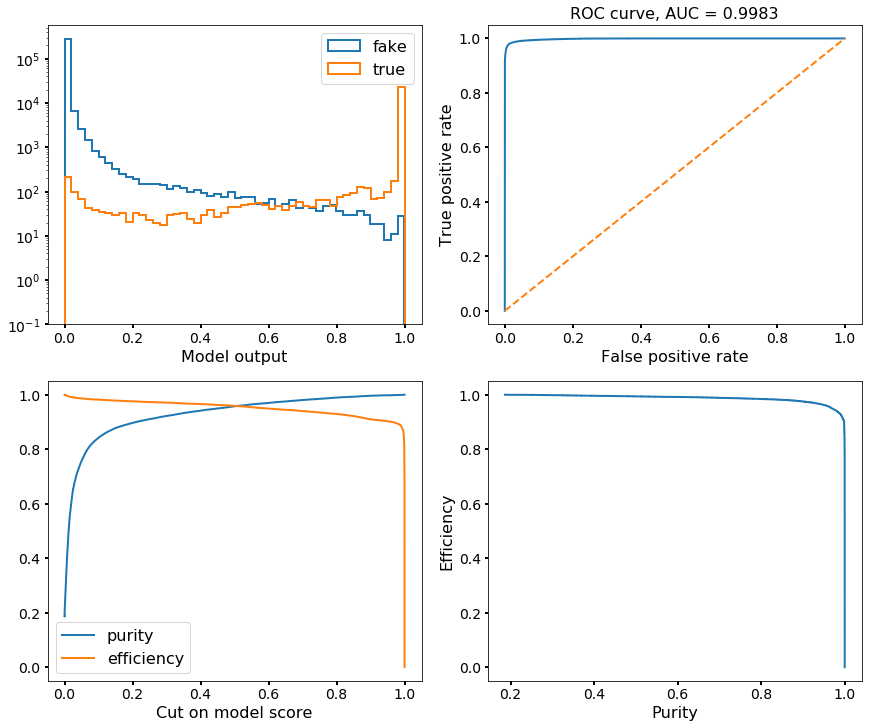

In [111]:
weights_ = []
truths_ = []
for G in predicted_graphs:
    weights_ += [G.edges[edge]['predict'][0] for edge in G.edges()]
    truths_  += [G.edges[edge]['solution'][0] for edge in G.edges()]

    
weights_ = np.array(weights_)
truths_ = np.array(truths_)
plot_metrics2(weights_, truths_, odd_th=0.5)

In [114]:
for input_nx_graph, predicted_graph in zip(input_nx_graphs, predicted_graphs):
    n_nodes_input = len(input_nx_graph.nodes())
    n_nodes_predict = len(predicted_graph.nodes())
    if n_nodes_input == n_nodes_predict:
        for inode in range(n_nodes_input):
            predicted_graph.node[inode].update(hit_id=input_nx_graph.node[inode]['hit_id'])
    else:
        print("Not the same")

In [252]:
predicted_graphs[0].node[0]

{'pos': array([ 0.81527752, -0.07366344, -0.0544    ]), 'hit_id': 103215}

In [253]:
all_predicted_nodes = sum([len(gg.nodes()) for gg in predicted_graphs])

In [254]:
print(all_predicted_nodes, hits_barrel_no_duplicate_hits.shape[0])

38753 38753


In [255]:
all_predicted_edges = sum([len(gg.edges()) for gg in predicted_graphs])

In [256]:
print(all_predicted_edges, splitted_selected_segments.shape[0])

318394 159197


In [257]:
predicted_graphs[0].edges[(0, 801)]

{'solution': array([0.]), 'predict': array([5.84421066e-06])}

In [112]:
def nx_to_pandas(nx_G):
    df_nodes = pd.DataFrame([(ii, nx_G.node[ii]['hit_id']) for ii in nx_G.nodes()],
                            columns=['node_idx', 'hit_id'])
    df_edges = pd.DataFrame([(ii, nx_G.node[ff[0]]['hit_id'], nx_G.node[ff[1]]['hit_id'], ff[2]['predict'][0], ff[2]['solution'][0]) 
                             for ii, ff in enumerate(nx_G.edges(data=True))],
                            columns=['edge_idx', 'sender', 'receiver', 'predict', 'solution'])
    return df_nodes, df_edges

In [115]:
segments_with_prediction = [nx_to_pandas(jj)[1] for jj in predicted_graphs]

In [116]:
merged_segments_with_prediction = pd.concat(segments_with_prediction, ignore_index=True)

In [261]:
merged_segments_with_prediction.head(1)

,edge_idx,sender,receiver,predict,solution
0,0,103215,87841,0.02781,0.0


In [117]:
def df_to_nx2(hits, segments, in_name='hit_id_1', out_name='hit_id_2'):

    n_nodes = hits.shape[0]
    n_edges = segments.shape[0]

    graph = nx.Graph()

    hits_id_dict = {}
    for idx in range(n_nodes):
        hit_id = int(hits.iloc[idx]['hit_id'])
        graph.add_node(idx, 
                       pos=hits.iloc[idx][['r', 'phi', 'z']],
                       hit_id=hit_id,
                       solution=[0.0])
        hits_id_dict[hit_id] = idx
        
    for idx in range(n_edges):
        in_hit_idx  = int(segments.iloc[idx][in_name])
        out_hit_idx = int(segments.iloc[idx][out_name])

        in_node_idx  = hits_id_dict[in_hit_idx]
        out_node_idx = hits_id_dict[out_hit_idx]

        graph.add_edge(out_node_idx, in_node_idx,
                       solution=np.array([segments.iloc[idx]['solution']]),
                       predict=np.array([segments.iloc[idx]['predict']])
                      )
    return graph

In [ ]:
hits_after_split_graph = hits_barrel_no_duplicate_hits[hits_barrel_no_duplicate_hits['particle_id'].isin()]

In [118]:
merged_segments_with_prediction.shape

(318394, 5)

In [150]:
merged_segments_with_prediction.head(1)

,edge_idx,sender,receiver,predict,solution
0,0,103215,87841,0.02781,0.0


In [148]:
### select segments that survives from above selections
particles_after_split_graph = n_trks_with_split['correct_pids']

In [149]:
hits_after_split_graph = hits_barrel_no_duplicate_hits[hits_barrel_no_duplicate_hits['particle_id'].isin(particles_after_split_graph)]

In [153]:
segments_with_prediction_after_split_graph = merged_segments_with_prediction[(merged_segments_with_prediction['sender'].isin(hits_after_split_graph['hit_id'].values)) & (merged_segments_with_prediction['receiver'].isin(hits_after_split_graph['hit_id'].values))]

In [154]:
nx_G_GNN_after_split_graph = df_to_nx2(hits_after_split_graph, segments_with_prediction_after_split_graph, in_name='sender', out_name='receiver')

In [156]:
all_gnn_tracks = wrangler.get_tracks(nx_G_GNN_after_split_graph, feature_name=feature_name, with_fit=False)

In [159]:
gnn_pred_tracks = analysis.graphs_to_df(all_gnn_tracks)

In [160]:
n_total_predictions = len(np.unique(gnn_pred_tracks['track_id']))
print(n_total_predictions)

2650


In [161]:
2590./2650

0.9773584905660377

In [165]:
n_trks_with_splitGNN_after_split = get_corrected_trks(nx_G_GNN_after_split_graph, truth, hits_after_split_graph, feature_name='predict')

total predictions: 2650


In [166]:
print_info(n_trks_with_splitGNN_after_split)

Correct 2612, Wrong 56, Isolated 0, Broken 0, Connected 56


In [167]:
2612/2650

0.9856603773584905

In [168]:
2612/38753

0.06740123345289396

In [119]:
nx_G_splitted_withPrediction = df_to_nx2(hits_barrel_no_duplicate_hits, merged_segments_with_prediction, in_name='sender', out_name='receiver')

In [120]:
print(len(nx_G_splitted_withPrediction))

38753


In [138]:
feature_name='predict'
all_gnn_tracks = wrangler.get_tracks(nx_G_splitted_withPrediction, feature_name=feature_name, with_fit=False)

In [141]:
gnn_pred_tracks = analysis.graphs_to_df(all_gnn_tracks)

In [142]:
n_total_predictions = len(np.unique(gnn_pred_tracks['track_id']))

In [143]:
n_total_predictions

24537

In [284]:
%%time
n_trks_with_splitGNN = get_corrected_trks(nx_G_splitted_withPrediction, truth, hits_barrel_no_duplicate_hits, feature_name='predict')

CPU times: user 12min 39s, sys: 13.5 s, total: 12min 52s
Wall time: 12min 53s


In [285]:
print_info(n_trks_with_splitGNN)

Correct 2590, Wrong 4902, Isolated 14, Broken 1286, Connected 3616


### pT distribution at different stages and their ratios

In [271]:
hits_barrel_no_dup_no_missing = hits_barrel_no_duplicate_hits[~hits_barrel_no_duplicate_hits['particle_id'].isin(broken_tracks)]

In [273]:
bb_no_missing_pids = np.unique(hits_barrel_no_dup_no_missing['particle_id'])
print(len(bb_no_missing_pids))

6600


array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

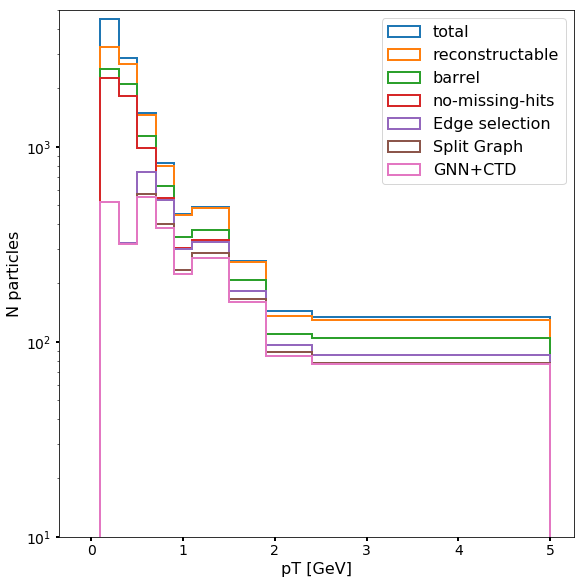

In [385]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
bins = [-0.1, 0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.5, 1.9, 2.4, 5]
hist_configs = {
    'bins': bins,
    'histtype': 'step',
    'lw': 2,
    'log': True
}

tot_vals, bins, _ = ax.hist(particles['pt'], **hist_configs, label='total')

constructable_vals, bins, _ = ax.hist(particles[particles['particle_id'].isin(np.unique(reconstructable_particles.particle_id))]['pt'],
                                  **hist_configs, label='reconstructable')

bb_vals, bins, _ = ax.hist(particles[particles['particle_id'].isin(barrel_particles)]['pt'], **hist_configs, label='barrel')
miss_hits_vals, bins, _ = ax.hist(particles[particles['particle_id'].isin(bb_no_missing_pids)]['pt'],
                                  **hist_configs, label='no-missing-hits')
graph_forming_vals, bins, _ = ax.hist(particles[particles['particle_id'].isin(n_fully_connected_trks['correct_pids'].values)]['pt'],
                                  **hist_configs, label='Edge selection')
split_graph_vals, bins, _ = ax.hist(particles[particles['particle_id'].isin(n_trks_with_split['correct_pids'].values)]['pt'],
                                  **hist_configs, label='Split Graph')
gnn_vals, bins, _ = ax.hist(particles[particles['particle_id'].isin(n_trks_with_splitGNN['correct_pids'].values)]['pt'],
                                  **hist_configs, label='GNN+CTD')
ax.set_ylabel('N particles', fontsize=fontsize)
ax.set_xlabel('pT [GeV]', fontsize=fontsize)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)
ax.set_ylim(10, 5000)
ax.legend(fontsize=fontsize)
plt.savefig("number_of_particles_vs_pt.eps")
plt.savefig("number_of_particles_vs_pt.png")

In [316]:
def get_ratio(x_vals, y_vals):
    res = [x/y if y!=0 else 0.0 for x,y in zip(x_vals, y_vals)]
    return res[1:]

In [ ]:
tot_ratio = get_ratio(tot_vals, tot_vals)
constructable_ratio = get_ratio(constructable_vals, tot_vals)
bb_ratio  = get_ratio(bb_vals, tot_vals)
misshits_ratio  = get_ratio(miss_hits_vals, tot_vals)
graphforming_ratio = get_ratio(graph_forming_vals, tot_vals)
graphsplit_ratio = get_ratio(split_graph_vals, tot_vals)
gnn_ratio = get_ratio(gnn_vals, tot_vals)

In [387]:
ratio_dict = {
    "total": tot_ratio, 
    "reconstructable": constructable_ratio,
    "barrel": bb_ratio,
    "no-missing-hits": misshits_ratio,
    'Edge selection': graphforming_ratio,
    'Split Graph': graphsplit_ratio,
    'GNN+CTD': gnn_ratio
}

In [372]:
gnn_ratio2 = get_ratio(gnn_vals, split_graph_vals)
print(gnn_ratio2)

[0.9923518164435946, 0.9968553459119497, 0.968365553602812, 0.955, 0.9527896995708155, 0.9507042253521126, 0.9636363636363636, 0.9438202247191011, 0.9871794871794872]


In [373]:
xvals = [0.5*(x[0]+x[1]) for x in utils_fit.pairwise(bins)][1:]

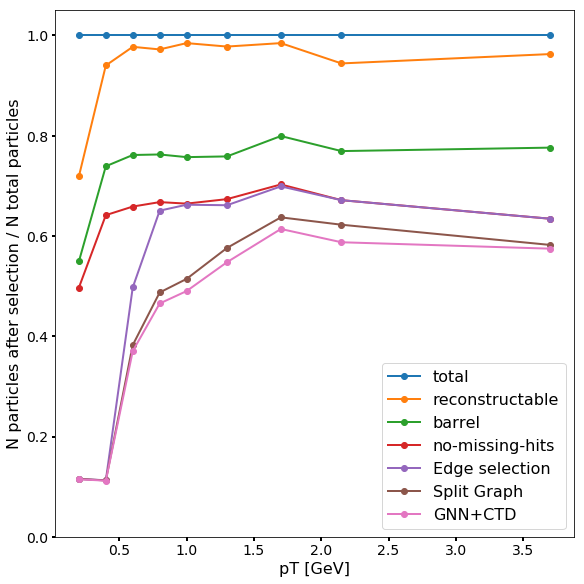

In [384]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

line_configs = {'lw': 2}
lstype = '-o'
ax.plot(xvals, tot_ratio, lstype, **line_configs, label="total")
ax.plot(xvals, constructable_ratio, lstype, **line_configs, label="reconstructable")
ax.plot(xvals, bb_ratio, lstype, **line_configs, label='barrel')
ax.plot(xvals, misshits_ratio, lstype, **line_configs, label='no-missing-hits')
ax.plot(xvals, graphforming_ratio, lstype, **line_configs, label='Edge selection')
ax.plot(xvals, graphsplit_ratio, lstype, **line_configs, label='Split Graph')
ax.plot(xvals, gnn_ratio, lstype, **line_configs, label='GNN+CTD')
ax.set_ylim(0, 1.05)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)
ax.set_ylabel("N particles after selection / N total particles", fontsize=fontsize)
ax.set_xlabel("pT [GeV]", fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.savefig("selection_efficiency_vs_particle_pt.eps")
plt.savefig("selection_efficiency_vs_particle_pt.png")

In [396]:
def plot_ratio(x, y_list, labels):
    fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

    line_configs = {'lw': 2}
    lstype = '-o'
    for y,label in zip(y_list, labels):
        ax.plot(x, y, lstype, **line_configs, label=label)
    ax.set_ylim(0, 1.05)
    ax.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)
    ax.set_ylabel("N particles after selection / N total particles", fontsize=fontsize)
    ax.set_xlabel("pT [GeV]", fontsize=fontsize)
    ax.legend(fontsize=fontsize, loc=4)
    plt.savefig("selection_efficiency_vs_particle_pt_{}.eps".format(label))
    plt.savefig("selection_efficiency_vs_particle_pt_{}.png".format(label))

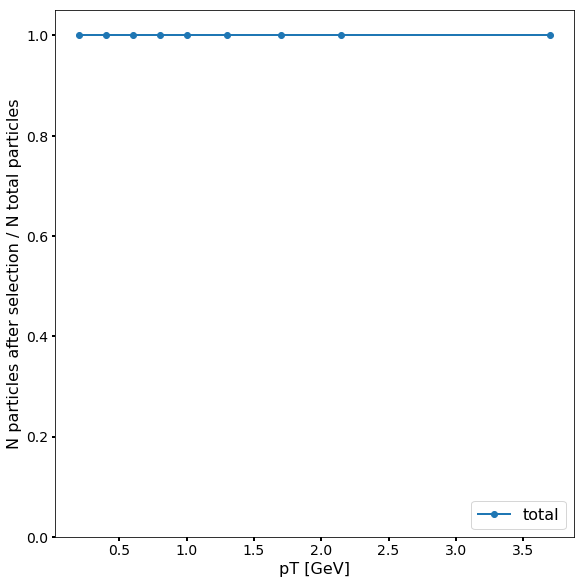

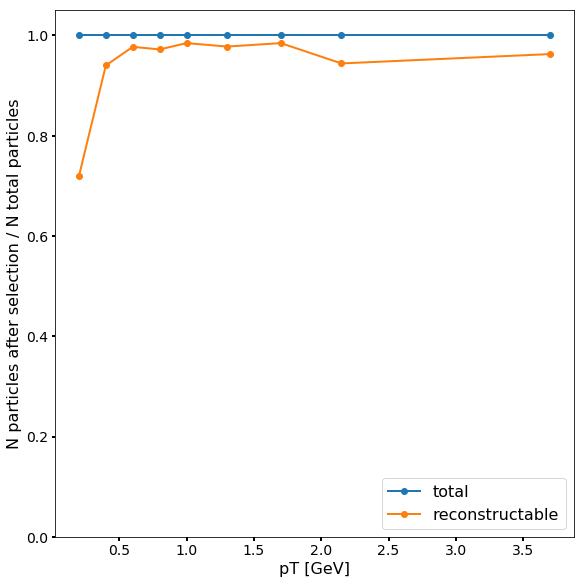

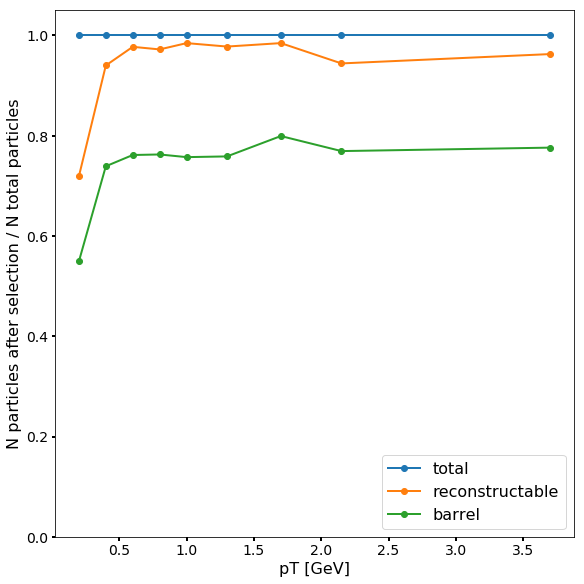

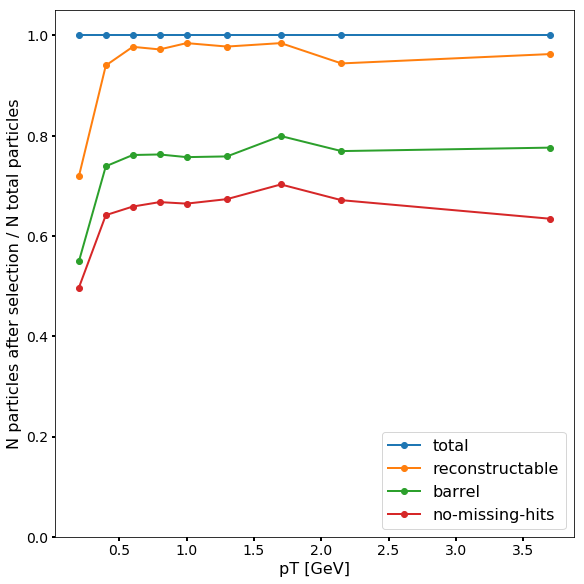

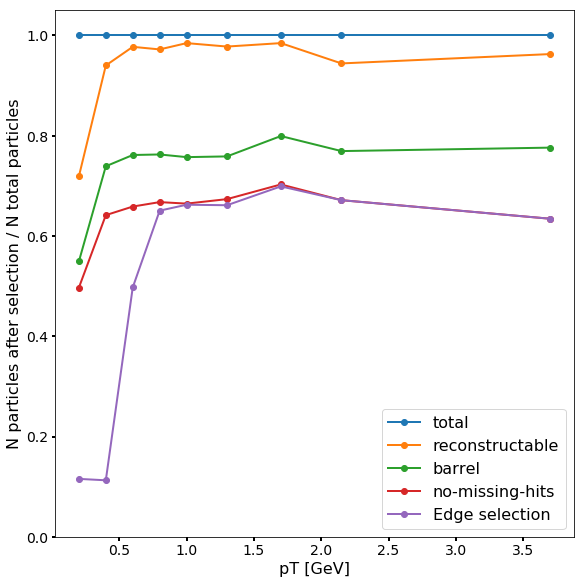

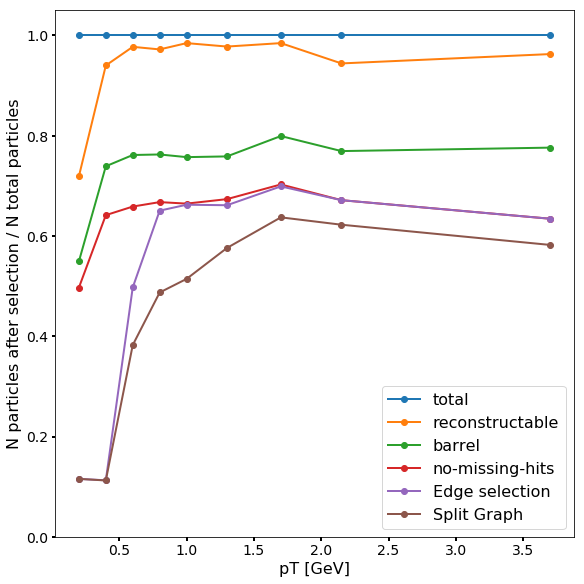

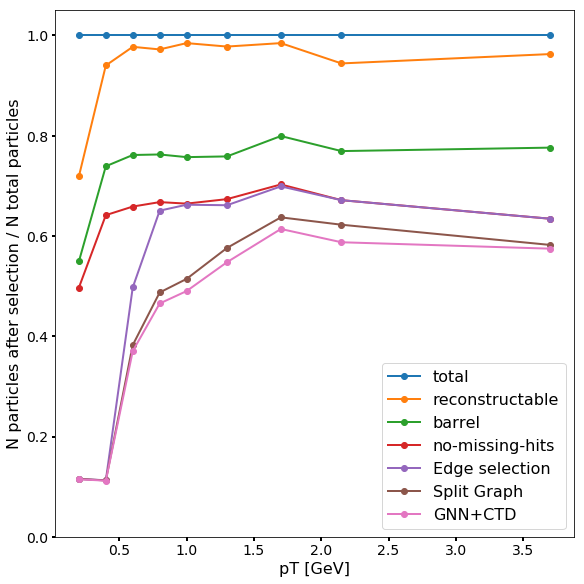

In [397]:
# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = prop_cycle.by_key()['color']
icolor = 0
ratio_to_plot = []
labels_to_plot = []
for key,value in ratio_dict.items():
    ratio_to_plot.append(value)
    labels_to_plot.append(key)
    plot_ratio(xvals, ratio_to_plot, labels_to_plot)
    icolor += 1

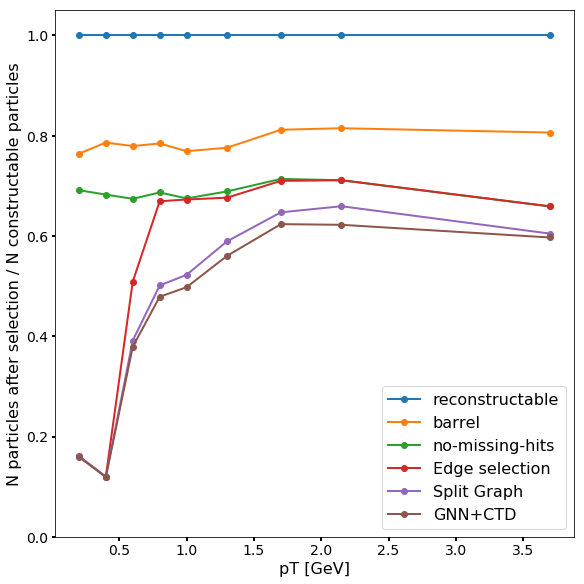

In [383]:
constructable_ratio2 = get_ratio(constructable_vals, constructable_vals)
bb_ratio2  = get_ratio(bb_vals, constructable_vals)
misshits_ratio2  = get_ratio(miss_hits_vals, constructable_vals)
graphforming_ratio2 = get_ratio(graph_forming_vals, constructable_vals)
graphsplit_ratio2 = get_ratio(split_graph_vals, constructable_vals)
gnn_ratio2 = get_ratio(gnn_vals, constructable_vals)


fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

line_configs = {'lw': 2}
lstype = '-o'
ax.plot(xvals, constructable_ratio2, lstype, **line_configs, label="reconstructable")
ax.plot(xvals, bb_ratio2, lstype, **line_configs, label='barrel')
ax.plot(xvals, misshits_ratio2, lstype, **line_configs, label='no-missing-hits')
ax.plot(xvals, graphforming_ratio2, lstype, **line_configs, label='Edge selection')
ax.plot(xvals, graphsplit_ratio2, lstype, **line_configs, label='Split Graph')
ax.plot(xvals, gnn_ratio2, lstype, **line_configs, label='GNN+CTD')
ax.set_ylim(0, 1.05)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)
ax.set_ylabel("N particles after selection / N constructable particles", fontsize=fontsize)
ax.set_xlabel("pT [GeV]", fontsize=fontsize)
ax.legend(fontsize=fontsize)
plt.savefig("selection_efficiency_wrt_constructable_vs_particle_pt.eps")
plt.savefig("selection_efficiency_wrt_constructable_vs_particle_pt.png")

No handles with labels found to put in legend.


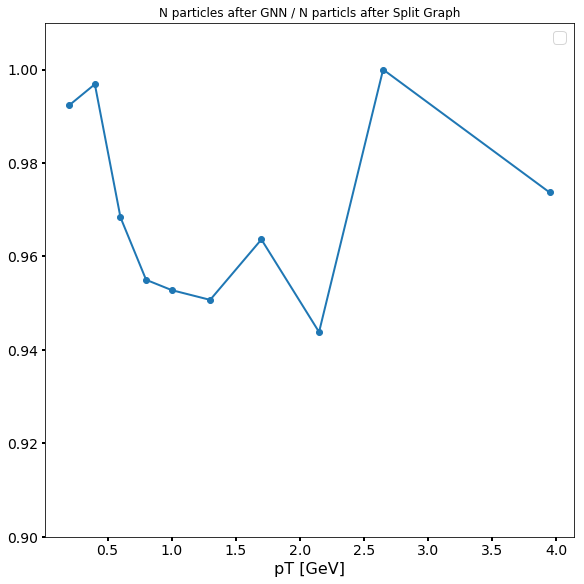

In [331]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

line_configs = {'lw': 2}
lstype = '-o'
ax.plot(xvals, gnn_ratio2, lstype, **line_configs)
ax.set_ylim(0, 1.05)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)
# ax.set_ylabel("N particles after GNN / N total particles after ", fontsize=fontsize)
ax.set_xlabel("pT [GeV]", fontsize=fontsize)
ax.set_title("N particles after GNN / N particls after Split Graph")
ax.set_ylim(0.9, 1.01)
ax.legend(fontsize=fontsize)